In [1]:
!python -m pip install numpy matplotlib seaborn tensorflow scikit-learn visualkeras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import normalize
import sklearn

sns.set_theme(style="dark") 
sns.set_palette('Set2')

2025-01-06 20:24:07.548140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736216647.565691     613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736216647.570034     613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 20:24:07.587356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
compound_library = {
    "methane": {
        "peak_positions": np.array([2917]),
        "peak_intensities": np.array([1.0])
    },
    "ethane": {
        "peak_positions": np.array([995, 1460, 2880]),
        "peak_intensities": np.array([0.5, 0.8, 1.0])
    },
    "propane": {
        "peak_positions": np.array([748, 992, 1460, 2883]),
        "peak_intensities": np.array([0.3, 0.4, 0.8, 1.0])
    },
    "annite": {
        "peak_positions": np.array([190, 650, 680, 3655]),
        "peak_intensities": np.array([0.6, 0.7, 0.75, 1.0])
    }
}

In [54]:
# Create a wavenumber axis (e.g., 400 to 3200 cm^-1).
# The choice of range depends on typical Raman shifts for organic molecules.
num_points = 500
wavenumbers = np.linspace(400, 3200, num_points)

# Gaussian width for the peaks
peak_width = 10.0

def generate_compound_spectrum(peak_positions, peak_intensities, wavenumbers, sigma=peak_width):
    """
    Generate a synthetic Raman spectrum for a single compound 
    with specified peak positions and intensities.
    """
    spectrum = np.zeros_like(wavenumbers)
    for pos, inten in zip(peak_positions, peak_intensities):
        # Gaussian peaks
        spectrum += inten * np.exp(-0.5 * ((wavenumbers - pos) / sigma)**2)
    # Normalize for convenience
    max_val = np.max(spectrum)
    if max_val > 0:
        spectrum /= max_val
    return spectrum

In [55]:
# Precompute reference spectra for each compound
reference_spectra = {}
for compound, data in compound_library.items():
    ref_spectrum = generate_compound_spectrum(
        data["peak_positions"],
        data["peak_intensities"],
        wavenumbers,
        sigma=peak_width
    )
    reference_spectra[compound] = ref_spectrum

In [56]:
def generate_mixture_spectrum(compounds, concentrations, reference_spectra, noise_level=0.03):
    """
    Generate a synthetic mixture spectrum by linearly combining 
    the reference spectra according to the provided concentrations.
    """
    spectrum = np.zeros_like(wavenumbers)
    
    for compound, concentration in zip(compounds, concentrations):
        spectrum += concentration * reference_spectra[compound]
    # Add some noise
    noise = np.random.normal(0, noise_level, size=spectrum.shape)
    poly = ((0.00000005 * (wavenumbers)) ** 2) + 0.2 + np.random.normal(0, 0.05)
    return spectrum + noise + poly

In [112]:
# Let's create a dataset
n_samples = 30000  # number of training samples
compounds = list(compound_library.keys())
M = len(compounds)

In [113]:
X_data = []
y_data = []

for _ in range(n_samples):
    # Generate random concentrations that sum to 1 (for simplicity).
    # In reality, you may allow them to be any set of random values.
    rand_concs = np.random.rand(M)
    rand_concs /= np.sum(rand_concs)  # normalize so sum=1

    for i in range(0, M):
        if np.random.rand() > 0.6:
            rand_concs[i] = 0
    
    # Get the synthetic mixture spectrum
    mixture_spectrum = generate_mixture_spectrum(compounds, rand_concs, reference_spectra)
    
    X_data.append(mixture_spectrum)
    y_data.append(rand_concs)

X_data = np.array(X_data)
y_data = np.array(y_data)

In [114]:
# Shuffle data
idx = np.random.permutation(n_samples)
X_data = normalize(X_data[idx])
y_data = y_data[idx]

In [115]:
# Train/test split
train_size = int(0.8 * n_samples)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [116]:
## Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build a TensorFlow Neural Network
regressor = Sequential([
    Dense(128, activation='relu', input_shape=(num_points,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(M, activation='linear')  # M outputs, one for each compound concentration
])

regressor.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

#regressor.load_weights('models/v7.keras')
#regressor.load_weights('models/model.keras')

# Train the model

regressor_history = regressor.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

regressor.save('models/schmegma.keras')

Epoch 1/100


/home/aniruth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0141 - mae: 0.0899 - root_mean_squared_error: 0.1166 - val_loss: 0.0027 - val_mae: 0.0376 - val_root_mean_squared_error: 0.0517
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0028 - mae: 0.0385 - root_mean_squared_error: 0.0531 - val_loss: 0.0026 - val_mae: 0.0374 - val_root_mean_squared_error: 0.0514
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025 - mae: 0.0363 - root_mean_squared_error: 0.0503 - val_loss: 0.0027 - val_mae: 0.0361 - val_root_mean_squared_error: 0.0516
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024 - mae: 0.0344 - root_mean_squared_error: 0.0488 - val_loss: 0.0022 - val_mae: 0.0330 - val_root_mean_squared_error: 0.0464
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0022 - mae: 0.0327 - root_mean_squared_error: 0.0466 - val_loss: 0.0026 - val_mae: 0.0355 - val_root_mean_squared_error: 0.0507
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [117]:
# Evaluate the Model
mse, mae, rmse = regressor.evaluate(X_test, y_test, verbose=1)
r2 = sklearn.metrics.r2_score(regressor.predict(X_test), y_test)
print(f"Test MSE: {mse}, Test MAE: {mae}, Test RMSE: {rmse}, Test R^2: {r2}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.0272 - root_mean_squared_error: 0.0416
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MSE: 0.0016812551766633987, Test MAE: 0.026942187920212746, Test RMSE: 0.041003111749887466, Test R^2: 0.9298480969912085


Text(0, 0.5, 'Intensity')

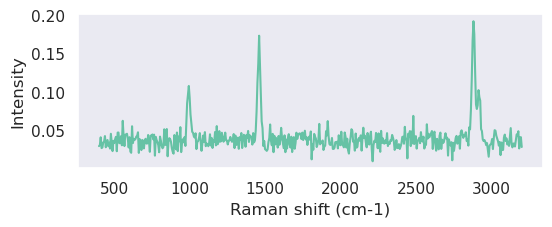

In [118]:
plt.figure(figsize=(6, 2))
plt.plot(wavenumbers, X_data[0])
plt.xlabel("Raman shift (cm-1)")
plt.ylabel("Intensity")

In [119]:
import ramanspy

In [120]:
spectrum_containers, metadata = ramanspy.datasets.rruff('fair_oriented')

In [122]:
annite = spectrum_containers[0]
#annite = ramanspy.preprocessing.misc.Cropper(region=(400, 3200)).apply(annite)

#ramanspy.plot.spectra(annite)
x_annite, y_annite = annite.spectral_axis, annite.spectral_data

import numpy as np
from scipy.interpolate import interp1d

def interpolate_function(x_values, y_values, kind='linear'):
    """
    Interpolates a set of x and y values to create a function f such that f(x) = y.

    Parameters:
    x_values (list or array): The x data points.
    y_values (list or array): The y data points.
    kind (str): The type of interpolation. Options include 'linear', 'quadratic', 'cubic'.

    Returns:
    function: A callable function that interpolates the data.
    """
    # Ensure the inputs are numpy arrays
    x = np.array(x_values)
    y = np.array(y_values)
    
    # Create the interpolating function
    f = interp1d(x, y, kind=kind, fill_value="extrapolate")
    
    return f

# AIST DATA GYATT
import matplotlib.pyplot as plt
import sklearn

f_interped = interpolate_function(x_annite, y_annite, kind='next')

num_points = 500
wavenumbers = np.linspace(400, 3200, num_points)
YY = list(map(f_interped, wavenumbers))
YY = np.array(YY)
YY = np.nan_to_num(YY)
YY = normalize(YY[:,np.newaxis], axis=0).ravel()
assert YY.shape == X_test[0].shape
#plt.plot(wavenumbers, YY)
YY = tf.convert_to_tensor(YY)
YY = tf.expand_dims(YY, axis=0)
regressor(YY)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.0309632 ,  0.01776625, -0.03365462, -0.03597055]],
      dtype=float32)>